Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [2]:
X, y = load_digits(return_X_y=True)

In [3]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

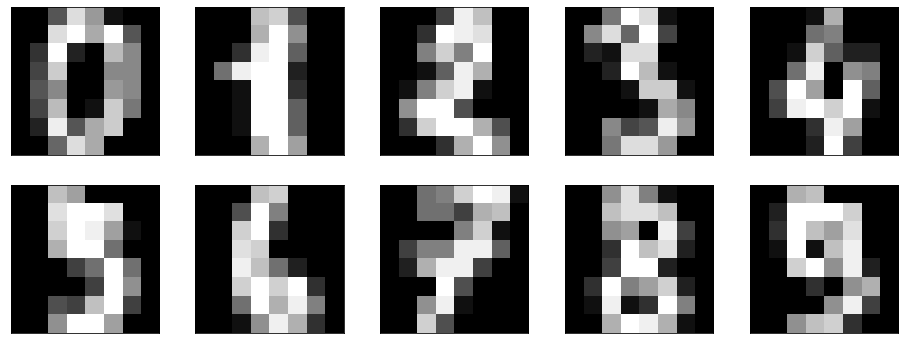

In [4]:
plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].reshape((8,8)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=300, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        return np.array([[np.sum((x - c) ** 2) for c in cluster_centers] for x in X])
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        updated_cluster_centers = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            updated_cluster_centers[i] = X[nearest_clusters == i].mean(axis=0)
        return np.nan_to_num(updated_cluster_centers, copy=False, nan=np.inf)
            
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
        best_objective = np.inf

        for i in range(self.n_init):
            objective_func_history = []
            # initialization (randomly assign a number from 0 to K-1 to each of the observations)
            labels = self.random_state.randint(self.n_clusters, size=X.shape[0])
            for j in range(self.max_iter):
                cluster_centers = self.update_centroids(X, labels)
                distances_to_centroids = self.calculate_distances_to_centroids(X, cluster_centers)
                labels = distances_to_centroids.argmin(axis=1)

                objective_func_history.append(np.array([distances_to_centroids[i, labels[i]] for i in range(X.shape[0])]).sum())
                
            objective = np.array([distances_to_centroids[i, labels[i]] for i in range(X.shape[0])]).sum()
            if objective < best_objective:
                best_objective = objective
                self.labels_ = labels
                self.cluster_centers_ = cluster_centers
                self.objective_history = objective_func_history
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>
            distances_to_centroids = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return distances_to_centroids.argmin(axis=1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
custom_kmeans = CustomKMeans(n_clusters=10)
custom_kmeans.fit(X);

In [8]:
custom_kmeans_labels = custom_kmeans.labels_
assert custom_kmeans_labels.shape == (1797,)

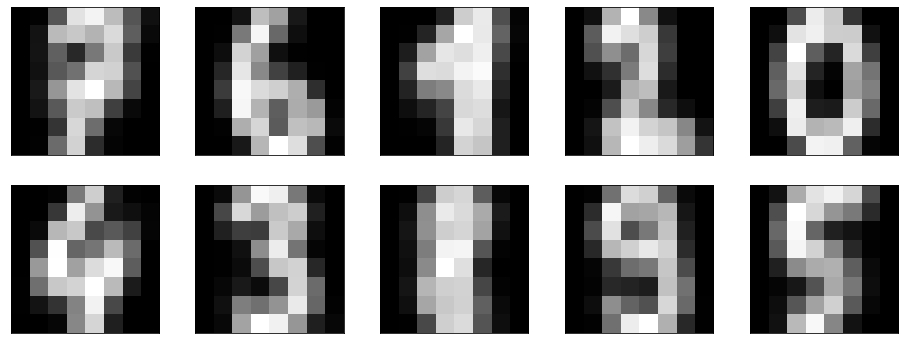

In [9]:
plt.figure(figsize=(16,6))
for i in range(custom_kmeans.cluster_centers_.shape[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(custom_kmeans.cluster_centers_[i].reshape((8,8)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

Average values of all observations belonging to the cluster indeed look like digits (the most unrecognizible ones are 7 and 8, but their shapes are still not so bad). So, our custom KMeans have done a pretty good job of clustering the digits.

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [10]:
def plot_loss(loss_history, parameters, parameter_name, title, xlabel, ylabel):
    plt.figure(figsize=(9, 4.5))
    for i in range(len(parameters)):
        plt.plot(loss_history[i], label=f'{parameter_name}={parameters[i]}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

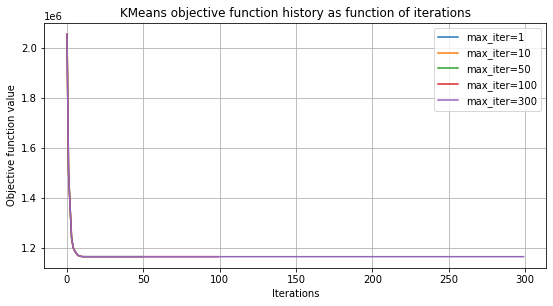

In [11]:
loss_history = []
iterations = [1, 10, 50, 100, 300]
for max_iter in iterations:
    model = CustomKMeans(n_clusters=10, max_iter=max_iter)
    model.fit(X)
    loss_history.append(model.objective_history)

plot_loss(loss_history, iterations, parameter_name='max_iter', title='KMeans objective function history as function of iterations', xlabel='Iterations', ylabel='Objective function value')

Looks like values are overlapping, let's plot them one at a time:

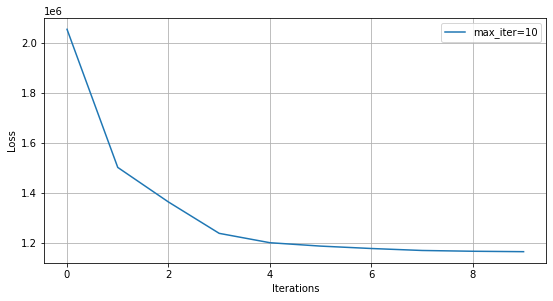

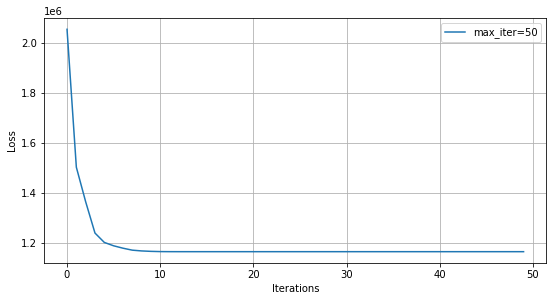

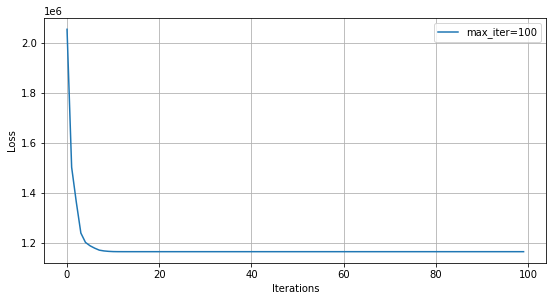

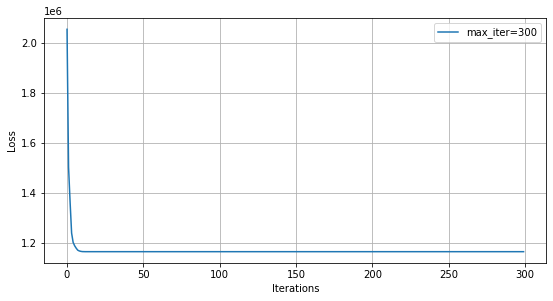

In [12]:
for i in range(1, len(loss_history)):
    plt.figure(figsize=(9, 4.5))
    plt.plot(loss_history[i], label=f'max_iter={iterations[i]}')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

It looks like we achieve minimum of objective function in less than 20 iterations.  
Let's have a look at the range of values of the objective function, it's best value and at what parameters they are achieved:

In [13]:
for i in range(len(loss_history)):
    print(f'max_iter={iterations[i]}')
    loss = np.array(loss_history[i])
    print(f'range of values: [{loss.min()}, {loss.max()}]')
    print(f'best value: {loss.min()}')
    print(f'number of iterations for which minimum objective value is obtained: {loss.argmin() + 1}')
    print()

max_iter=1
range of values: [2015581.6759105953, 2015581.6759105953]
best value: 2015581.6759105953
number of iterations for which minimum objective value is obtained: 1

max_iter=10
range of values: [1166449.9213235574, 2054132.4757990772]
best value: 1166449.9213235574
number of iterations for which minimum objective value is obtained: 10

max_iter=50
range of values: [1165143.857922732, 2054132.4757990772]
best value: 1165143.857922732
number of iterations for which minimum objective value is obtained: 15

max_iter=100
range of values: [1165143.857922732, 2054132.4757990772]
best value: 1165143.857922732
number of iterations for which minimum objective value is obtained: 15

max_iter=300
range of values: [1165143.857922732, 2054132.4757990772]
best value: 1165143.857922732
number of iterations for which minimum objective value is obtained: 15



We see that algorithm converges on our dataset in 15 iterations, after 15 iterations value of our objective function doesn't decrease. Minimum obtained value is 1165143.857922732

Now let's experimnet with n_init parameter (I will set max_iter parameter to 15 because we saw that this is enough):

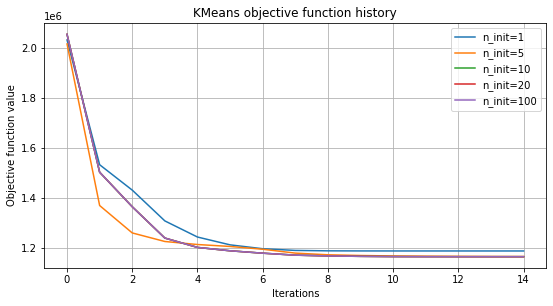

In [14]:
loss_history = []
n_init = [1, 5, 10, 20, 100]
for n in n_init:
    model = CustomKMeans(n_clusters=10, n_init=n, max_iter=15)
    model.fit(X)
    loss_history.append(model.objective_history)

plot_loss(loss_history, n_init, parameter_name='n_init', title='KMeans objective function history', xlabel='Iterations', ylabel='Objective function value')

Curves for n_init=10 and n_init=20 are overlapped by n_init=100, let's look at them separately:

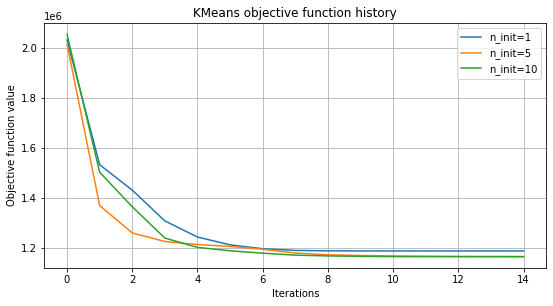

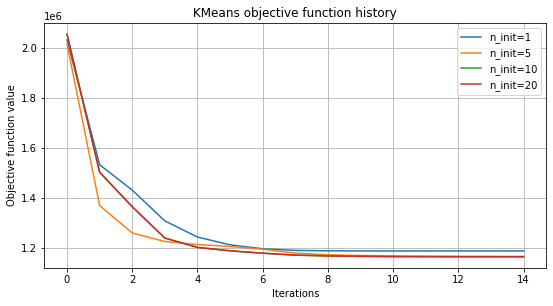

In [15]:
plot_loss(loss_history[:3], n_init[:3], parameter_name='n_init', title='KMeans objective function history', xlabel='Iterations', ylabel='Objective function value')
plot_loss(loss_history[:4], n_init[:4], parameter_name='n_init', title='KMeans objective function history', xlabel='Iterations', ylabel='Objective function value')

In [16]:
for i in range(len(loss_history)):
    print(f'n_init={n_init[i]}')
    loss = np.array(loss_history[i])
    print(f'range of values: [{loss.min()}, {loss.max()}]')
    print(f'best value: {loss.min()}')
    print()

n_init=1
range of values: [1187956.7567498419, 2031537.5866992753]
best value: 1187956.7567498419

n_init=5
range of values: [1165592.4405371987, 2015581.6759105953]
best value: 1165592.4405371987

n_init=10
range of values: [1165143.857922732, 2054132.4757990772]
best value: 1165143.857922732

n_init=20
range of values: [1165143.857922732, 2054132.4757990772]
best value: 1165143.857922732

n_init=100
range of values: [1165143.857922732, 2054132.4757990772]
best value: 1165143.857922732



Indeed, we see that our algorithm finds best objective value (1165143.857922732) in 10 runs, there is no point in making more runs.  

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [17]:
hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical.fit(X)

kmeans = KMeans(n_clusters=10)
kmeans.fit(X);

In [18]:
hierarchical_labels = hierarchical.labels_
kmeans_labels = kmeans.labels_

In [19]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

Cluster centers obtained by hierarchical clustering:

In [20]:
hierarchical_cluster_centers = np.zeros((hierarchical.n_clusters_, X.shape[1]))
for i in range(hierarchical.n_clusters_):
    hierarchical_cluster_centers[i] = X[hierarchical_labels == i].mean(axis=0)

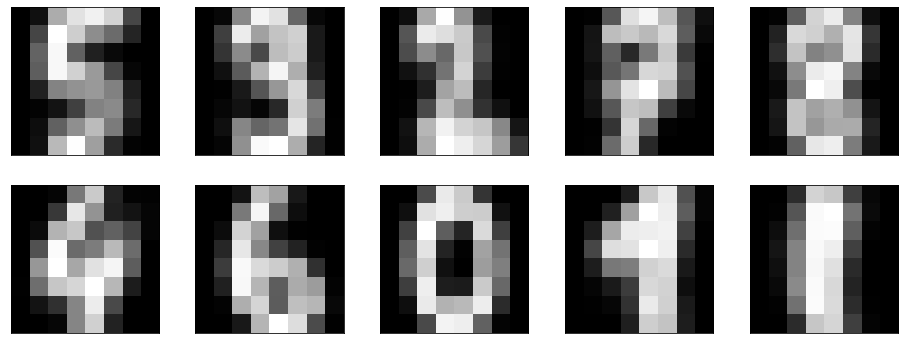

In [21]:
plt.figure(figsize=(16,6))
for i in range(hierarchical_cluster_centers.shape[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(hierarchical_cluster_centers[i].reshape((8,8)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

Cluster centers obtained by sklearn's KMeans:

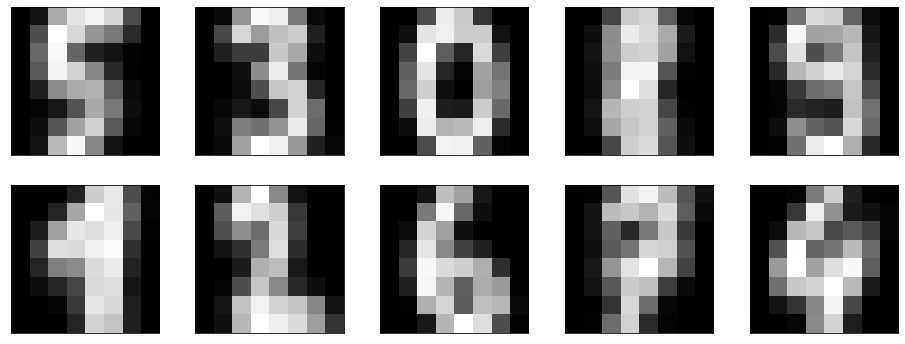

In [22]:
plt.figure(figsize=(16,6))
for i in range(kmeans.cluster_centers_.shape[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(kmeans.cluster_centers_[i].reshape((8,8)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

We got clearer shapes of the digits using KMeans algorithm.

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [23]:
def plot_score(x, scores_hierarchical, scores_kmeans, title, ylabel):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, scores_hierarchical, label='Hierarchical')
    plt.plot(x, scores_kmeans, color='C1', label='KMeans')
    plt.axvline(n_clusters[np.argmax(scores_hierarchical)], lw=10, alpha=0.2)
    plt.axvline(n_clusters[np.argmax(scores_kmeans)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel('n_clusters')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(n_clusters)
    plt.legend(loc='lower right')               
    plt.show()

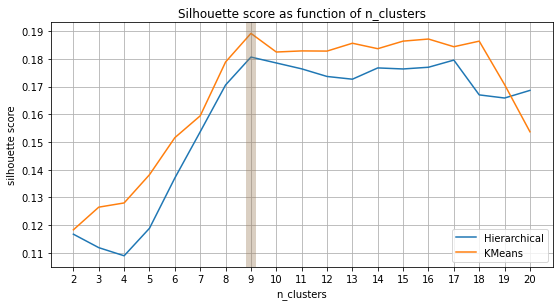

In [24]:
silhouette_scores_hierarchical = []
silhouette_scores_kmeans = []
n_clusters = np.arange(2,21,1)
for k in n_clusters:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    hierarchical.fit(X)
    silhouette_scores_hierarchical.append(silhouette_score(X, hierarchical.labels_))
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))

plot_score(n_clusters, silhouette_scores_hierarchical, silhouette_scores_kmeans, title='Silhouette score as function of n_clusters', ylabel='silhouette score')

We get maximum silhouette value with n_clusters=9 for both hierachical and KMeans clustering (almost 10, which is expectable number of clusters). We can explain smaller number of clusters by the fact that some numbers have very similar outlines or, in other words, feature descriptions in a vector space of size 64 (especially in such a small resolution as 8x8). For example, 1 and 7 could be considered as one cluster and we will get 9 clusters instead of 10.  
Generally, KMeans gives us higher silhouette values, which is consistent with our previous results (digits outlines obtained from KMeans cluster centers look more recognizible).

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

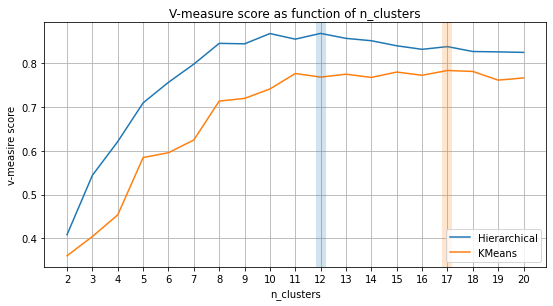

In [25]:
v_measure_scores_hierarchical = []
v_measure_scores_kmeans = []
n_clusters = np.arange(2,21,1)
for k in n_clusters:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    hierarchical.fit(X)
    v_measure_scores_hierarchical.append(v_measure_score(labels_true=y, labels_pred=hierarchical.labels_))
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    v_measure_scores_kmeans.append(v_measure_score(labels_true=y, labels_pred=kmeans.labels_))

plot_score(n_clusters, v_measure_scores_hierarchical, v_measure_scores_kmeans, title='V-measure score as function of n_clusters', ylabel='v-measire score')

We get maximum value of V-score when n_clusters=12 for hierachical clustering and when n_clusters=17 for Kmeans. But we can see on the plot that V-score increases up to 10-11 n_clusters and after that changes are not so significant, what corresponds to our expectations.  
We see that hierachical clustering gives us higher V-score values. I guess it can be explained by nature of hierachical clustering and how V-score is computed. V-measure is harmonic mean of homogeneity and completness (clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class and clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster). And it is exactly how agglomerative clustering works: it starts with assigning each data point to a distinct cluster (perfect homogeneity) and sequentially combine similar clusters (decreasing homogeneity and increasing completeness) until only one cluster is obtained (perfect completeness), while results of division data into clusters by KMeans can vary a lot depending on random initial assignment of centroids.

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [26]:
n_components = [2, 5, 10, 20]
silhouette_scores_hierarchical, silhouette_scores_kmeans = [], []
v_measure_scores_hierarchical, v_measure_scores_kmeans = [], []

for n in n_components:
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_reduced = svd.fit_transform(X)

    hierarchical = AgglomerativeClustering(n_clusters=10)
    hierarchical.fit(X_reduced)
    silhouette_scores_hierarchical.append(silhouette_score(X, hierarchical.labels_))
    v_measure_scores_hierarchical.append(v_measure_score(labels_true=y, labels_pred=hierarchical.labels_))
    
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(X_reduced)
    silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))
    v_measure_scores_kmeans.append(v_measure_score(labels_true=y, labels_pred=kmeans.labels_))

# values obtained from original data
hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical.fit(X)
silhouette_scores_hierarchical.append(silhouette_score(X, hierarchical.labels_))
v_measure_scores_hierarchical.append(v_measure_score(labels_true=y, labels_pred=hierarchical.labels_))
    
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)
silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))
v_measure_scores_kmeans.append(v_measure_score(labels_true=y, labels_pred=kmeans.labels_))

pd.DataFrame({
    'silhouette_hierarchical': silhouette_scores_hierarchical,
    'v_measure_hierachical': v_measure_scores_hierarchical,
    'silhouette_kmeans': silhouette_scores_kmeans,
    'v_measure_kmeans': v_measure_scores_kmeans,
}, index=['d=2', 'd=5', 'd=10', 'd=20', 'original'])
    

,silhouette_hierarchical,v_measure_hierachical,silhouette_kmeans,v_measure_kmeans
d=2,-0.007681,0.333719,0.006295,0.346584
d=5,0.162011,0.675604,0.168598,0.635143
d=10,0.176588,0.825975,0.180464,0.721569
d=20,0.169133,0.814388,0.182149,0.740308
original,0.178497,0.868170,0.182443,0.741468


We see that the more the number of dimensions, the better metrics we get. And we obtain max metrics on our original data. 
Our feature space (64) is not so large and features are not so correlated with each other, therefore, by performing SVD, we rather lost some useful information than got rid of redundant one.  
But if we ignore metrics on original data (because we will always lose some information by performing dimensionality reduction), then we get the highest silhouette score with d=10 (significantly less than 64) and the highest V-score with d=20, and this is not much worse than score obtained on all features. So, if for some reasons (reduce memory required to store data, speed up algorithm) we have to reduce our feature space, then SVD can give pretty good results.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

C:\Users\sbsab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sbsab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


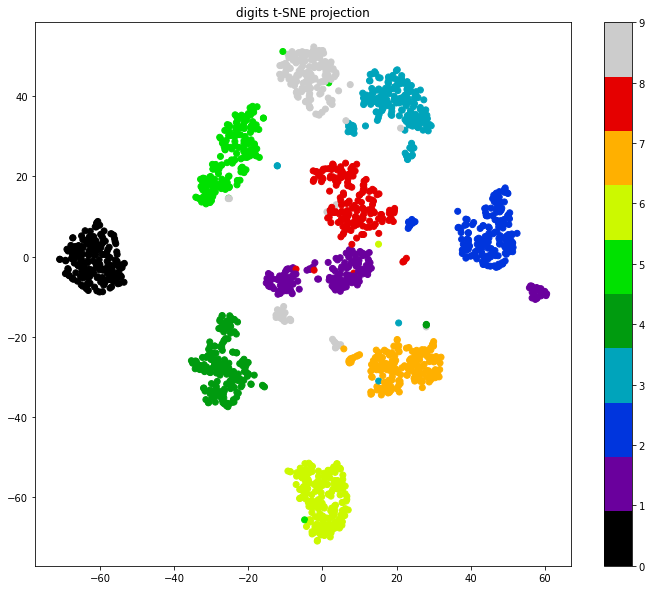

In [27]:
tsne = TSNE(random_state=42)
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('digits t-SNE projection')
plt.show()

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [28]:
silhouette_scores_hierarchical, silhouette_scores_kmeans = [], []
v_measure_scores_hierarchical, v_measure_scores_kmeans = [], []

hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical.fit(X_reduced)
silhouette_scores_hierarchical.append(silhouette_score(X, hierarchical.labels_))
v_measure_scores_hierarchical.append(v_measure_score(labels_true=y, labels_pred=hierarchical.labels_))
    
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_reduced)
silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))
v_measure_scores_kmeans.append(v_measure_score(labels_true=y, labels_pred=kmeans.labels_))

# values obtained from original data
hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical.fit(X)
silhouette_scores_hierarchical.append(silhouette_score(X, hierarchical.labels_))
v_measure_scores_hierarchical.append(v_measure_score(labels_true=y, labels_pred=hierarchical.labels_))
    
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)
silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))
v_measure_scores_kmeans.append(v_measure_score(labels_true=y, labels_pred=kmeans.labels_))

pd.DataFrame({
    'silhouette_hierarchical': silhouette_scores_hierarchical,
    'v_measure_hierachical': v_measure_scores_hierarchical,
    'silhouette_kmeans': silhouette_scores_kmeans,
    'v_measure_kmeans': v_measure_scores_kmeans,
}, index=['t-SNE', 'original'])

,silhouette_hierarchical,v_measure_hierachical,silhouette_kmeans,v_measure_kmeans
t-SNE,0.164145,0.920765,0.162783,0.912037
original,0.178497,0.868170,0.182443,0.741468


After transformation, V-score increased quite noticeably for both hierachical and KMeans clustering, silhouette value decreased slightly. We can conclude that t-SNE clusterize digits very well in terms of homogeneity and completeness.

For the sake of comparison, let's visualize data transformed by SVD:

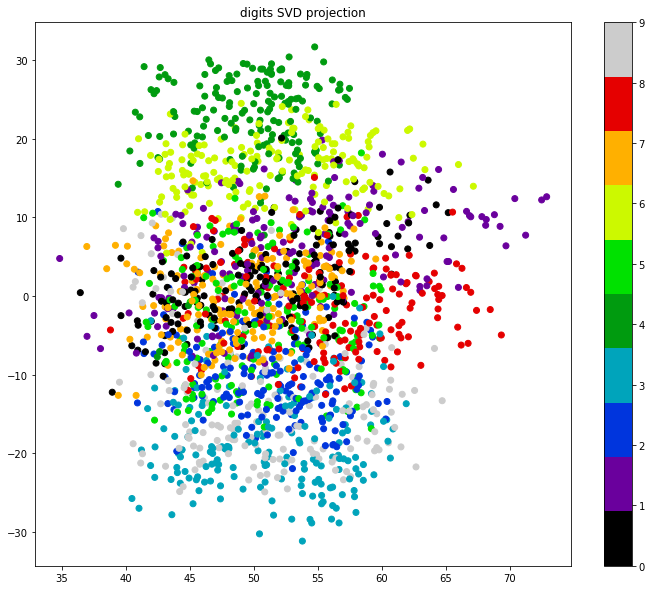

In [29]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('digits SVD projection')
plt.show()

We can see that t-SNE does a better job as compared to SVD when it comes to visualization. SVD is a linear projection, which means it can’t capture non-linear dependencies, as opposed to t-SNE.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

We get the best partition in terms of V-score with hierarchical clustering on data transformed by t-SNE:

C:\Users\sbsab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sbsab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


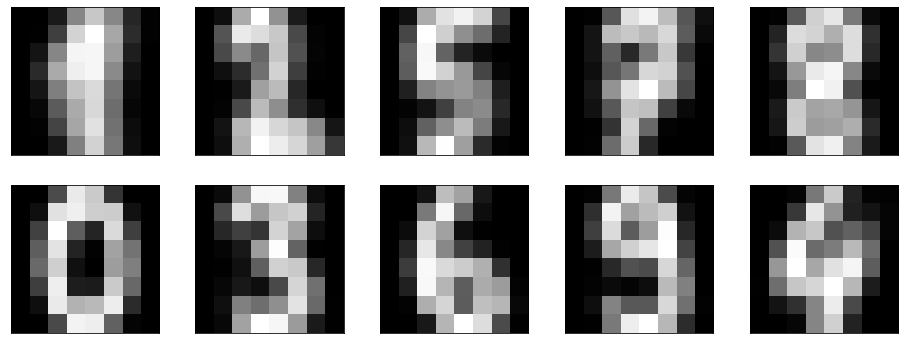

In [30]:
tsne = TSNE(random_state=42)
X_reduced = tsne.fit_transform(X)

hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical.fit(X_reduced)

hierarchical_cluster_centers = np.zeros((hierarchical.n_clusters_, X.shape[1]))
for i in range(hierarchical.n_clusters_):
    hierarchical_cluster_centers[i] = X[hierarchical.labels_ == i].mean(axis=0)

plt.figure(figsize=(16,6))
for i in range(hierarchical_cluster_centers.shape[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(hierarchical_cluster_centers[i].reshape((8,8)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

Yes, it is clearly seen that the center of each cluster corresponds to each digit, and visually this result is the best obtained so far.  
Let's visualize cluster centers of KMeans on data transformed by t-SNE:

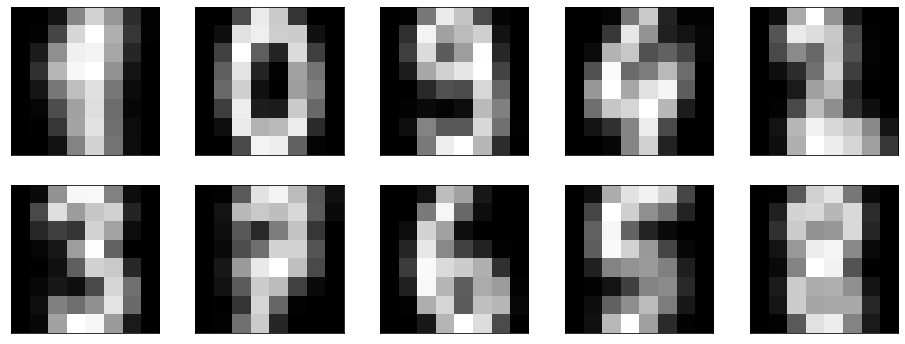

In [31]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_reduced)

kmeans_cluster_centers = np.zeros((kmeans.cluster_centers_.shape[0], X.shape[1]))
for i in range(kmeans.cluster_centers_.shape[0]):
    kmeans_cluster_centers[i] = X[kmeans.labels_ == i].mean(axis=0)

plt.figure(figsize=(16,6))
for i in range(kmeans_cluster_centers.shape[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(kmeans_cluster_centers[i].reshape((8,8)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

Vusially, results look the same as with hiearachical clustering.  

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

When we performed clustering on our original data, K-means gave us more meaningfull results visually and it's silhouette score was higher, while V-score was higher for hierarchical clustering (so, yes, results depend on quality evaluation method). After performing clustering on reduced data (using t-SNE) both silhouette and V-score are higher with hierarchical clustering than with K-means, but compared to the original data, the silhouette decreased and the V-score increased for both clustering methods, while visually we got equally better results with both approaches.  

So, we can conclude that there is no simple recipe or general rule that could always be applied. We should try different approaches and build on the goals we want to achieve.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

For each new data point, we can find nearest observation in training set and assign corresponding cluster label (kind of KNN with n_neighbors=1). Generalizing that idea: we can train new classification model based on cluster labels, which were assigned during clustering, and then use this model to predict cluster. I really don't know how to measure quality of clustering in this case, maybe to attract some domain expert, who would evaluate meaningfulness of obtained results.

**(0.5 points)** Does dimensionality reduction improve clustering results?

SVD didn't give any improvements in metrics, as well as in visualization. But with t-SNE, we got a significant increase in the V-score and improved the clustering results, which were seen in clearer outlines of the numbers. In addition, with t-SNE we clearly see that digits separate into clusters even with just 2 dimensions, which isn't possible with SVD because it can't capture non-linear dependencies.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

1) repeat the same steps as we produced in this homework: reduce data and visualize it to see if it is possible to clusterize it/if we have achieved any meaningful results, or reduce data, perform clusterizing and calculate silhouette (V-score if true labels are available);
2) for PCA and SVD we can reconstruct the data from the reduced one and compare reconstructed data with the original one

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.